# Baseline model for flight delay

In [1]:
    # Import packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, date, time, timedelta

import init
import baseline_model as bm

In [2]:
# Load data
df_train = init.load_data("train")

In [3]:
# Calculate duration
df_train["DURATION"] = (df_train.STA - df_train.STD) / timedelta(minutes = 1)
df_train[["STD","STA","DURATION","target"]].sort_values("DURATION",ascending=False)

,STD,STA,DURATION,target
68355,2017-05-19 05:00:00,2018-09-30 21:00:00,719520.0,0.0
104441,2018-09-30 22:00:00,2019-11-20 21:00:00,598980.0,0.0
107433,2018-11-16 21:00:00,2019-12-24 21:00:00,580320.0,0.0
104084,2018-03-25 00:00:00,2019-03-31 00:00:00,534240.0,0.0
68102,2017-03-26 00:00:00,2018-03-25 00:00:00,524160.0,0.0
...,...,...,...,...
31899,2016-09-16 15:30:00,2016-09-16 15:40:00,10.0,0.0
31862,2016-04-13 12:30:00,2016-04-13 12:40:00,10.0,0.0
29655,2016-08-17 12:30:00,2016-08-17 12:40:00,10.0,0.0
29681,2016-08-14 12:30:00,2016-08-14 12:40:00,10.0,0.0


(-2.0, 100.0)

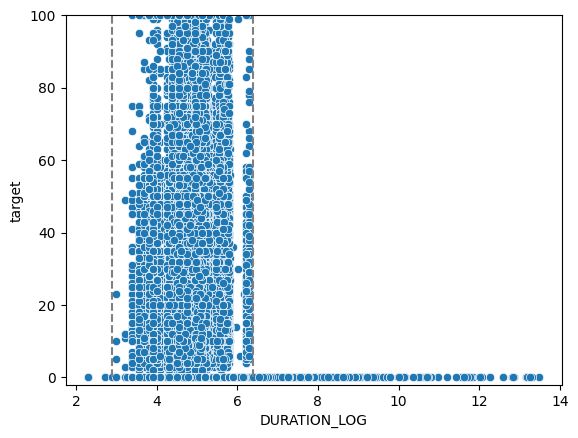

In [ ]:
# DURATION is very skewed, therefore it will be log transformed
df_train["DURATION_LOG"] = df_train["DURATION"].transform("log")
sns.scatterplot(df_train,x="DURATION_LOG",y="target")
plt.vlines(x=[2.9,6.4],ymin=0,ymax=3500,linestyles='dashed',colors="gray")
plt.ylim((-2,100))

## Baseline model 1)

The first baseline model should be the following:
\begin{aligned}
IF\ &the\ logarithmic\ duration\ is\ smaller\ than\ 2.9\ or\ bigger\ than\ 6.4\\
&target = 0\\
ELSE\\
&target\ =\ mean(target)\ of\ all\ flights\ with\ logarithmic\ duration\ in\ [2.9,6.4]\\
\end{aligned}

The metric which should be used is the RMSE


In [5]:
# Get the median target for all flights with log duration in [2.9,6.4]

target_mean = round(df_train[(2.9 <= df_train["DURATION_LOG"]) & (df_train["DURATION_LOG"] <= 6.4)]["target"].mean(),2)
target_median = round(df_train[(2.9 <= df_train["DURATION_LOG"]) & (df_train["DURATION_LOG"] <= 6.4)]["target"].median(),2)

print("The mean is", target_mean)
print("The median is", target_median)

The mean is 49.11
The median is 14.0


In [6]:
# Predict target values from train
y_predict_mean   = bm.baseline_model(df_train,value=target_mean)
y_predict_median = bm.baseline_model(df_train,value=target_median)
y_predict_zero   = bm.baseline_model(df_train,value=0)

In [7]:
# Get RMSE for train data
from sklearn.metrics import mean_squared_error

print("RMSE for using mean as value:",round(np.sqrt(mean_squared_error(df_train["target"],y_predict_mean)),2))
print("RMSE for using median as value:",round(np.sqrt(mean_squared_error(df_train["target"],y_predict_median)),2))
print("RMSE for using 0 as value:",round(np.sqrt(mean_squared_error(df_train["target"],y_predict_zero)),2))

RMSE for using mean as value: 117.06
RMSE for using median as value: 122.17
RMSE for using 0 as value: 126.87


## Baseline model 2)

The second baseline model should be the following:
\begin{aligned}
IF\ &STATUS\ is\ in\ SCH\ or\ DEL\\
&target = 0\\
ELSE\\
&target\ =\ mean(target)\ of\ all\ flights\ with\ STATUS\ not\ in\ SCH\ or\ DEL\\
\end{aligned}

The metric which should be used is the RMSE


In [8]:
# Get the median target for all flights with STATUS not in SCH, DEL

target_mean = round(df_train[(df_train["STATUS"] != "DEL") & (df_train["STATUS"] != "SCH")]["target"].mean(),2)
target_median = round(df_train[(df_train["STATUS"] != "DEL") & (df_train["STATUS"] != "SCH")]["target"].median(),2)

print("The mean is", target_mean)
print("The median is", target_median)

The mean is 55.64
The median is 19.0


In [9]:
# Predict target values from train
y_predict_mean   = bm.baseline_model2(df_train,value=target_mean)
y_predict_median = bm.baseline_model2(df_train,value=target_median)
y_predict_zero   = bm.baseline_model2(df_train,value=0)

In [10]:
# Get RMSE for train data
from sklearn.metrics import mean_squared_error

print("RMSE for using mean as value:",round(np.sqrt(mean_squared_error(df_train["target"],y_predict_mean)),2))
print("RMSE for using median as value:",round(np.sqrt(mean_squared_error(df_train["target"],y_predict_median)),2))
print("RMSE for using 0 as value:",round(np.sqrt(mean_squared_error(df_train["target"],y_predict_zero)),2))

RMSE for using mean as value: 115.69
RMSE for using median as value: 120.66
RMSE for using 0 as value: 126.87


In [19]:
# Get Accuracy for train data using the following approach:
# IF y_predict IN [y_train-10,y_train+10]
#     correct predicted
# ELSE
#     wrongly predicted

print("Accuracy for using mean as value:",round(bm.get_accuracy(df_train["target"],y_predict_mean,10),2))
print("Accuracy for using median as value:",round(bm.get_accuracy(df_train["target"],y_predict_median,10),2))
print("Accuracy for using 0 as value:",round(bm.get_accuracy(df_train["target"],y_predict_zero,10),2))

Accuracy for using mean as value: 0.19
Accuracy for using median as value: 0.36
Accuracy for using 0 as value: 0.46


In [20]:
from sklearn.metrics import make_scorer

score_func = make_scorer(bm.get_accuracy)